In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

losses = []

for i in range(1, 9, 2):
    MIN = 100
    EPOCH = 0
    current_losses = []
    with open(f'alpha_gumbel_selector_log{i}.txt') as f:
        lines = f.readlines()
        for j in range(20, 420):
            loss = float(lines[j][-11:])
            current_losses.append(loss)
            if loss < MIN:
                MIN = loss
                EPOCH = j - 19
    print(f'alpha_gumbel_selector_log{i}.txt: {MIN:.3f} at epoch {EPOCH}')

    # assume `losses` is your list or 1D array of epoch losses
    loss_array = np.array(current_losses)

    # 1) rolling‐window parameters
    window = 30
    kernel = np.ones(window) / window

    # 2) compute the “valid” convolution
    rolling = np.convolve(loss_array, kernel, mode='valid')

    # 3) figure out how to align it so it’s centered under the raw curve
    shift = (window - 1) // 2  # integer shift

    # 4) plotting
    plt.figure(figsize=(10, 5))
    plt.plot(loss_array, label='Raw Loss', color='blue', alpha=0.3)
    plt.plot(
        np.arange(shift, shift + len(rolling)),
        rolling,
        label=f'{window}-Epoch Rolling Avg',
        color='red',
        linewidth=2
    )

    plt.title('Loss over Epochs (with Rolling Average)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.savefig(f'alpha_gumbel_selector_plot{i}.png', dpi=500)
    plt.close()
    losses.append(current_losses)
                

alpha_gumbel_selector_log1.txt: 0.697 at epoch 7
alpha_gumbel_selector_log3.txt: 0.721 at epoch 23
alpha_gumbel_selector_log5.txt: 0.545 at epoch 272
alpha_gumbel_selector_log7.txt: 0.555 at epoch 198


In [34]:
losses_df = pd.DataFrame(losses).T
models = ['MSE@1e-3', 'MSE@3e-4', 'MAE@1e-3', 'MAE@3e-4']
losses_df.columns = models
losses_df

,MSE@1e-3,MSE@3e-4,MAE@1e-3,MAE@3e-4
0,1.146922,0.988737,0.773306,0.654369
1,1.239639,1.183243,0.864353,0.658765
2,0.982973,1.020894,0.857431,0.776228
3,0.697674,1.085975,0.876819,0.581827
4,0.697021,0.953492,0.748468,0.700183
...,...,...,...,...
395,0.973153,0.900027,1.133473,0.762255
396,0.977751,0.888409,0.962235,0.729928
397,0.962867,0.857863,1.090084,0.719769
398,0.953561,0.832952,0.970307,0.722602


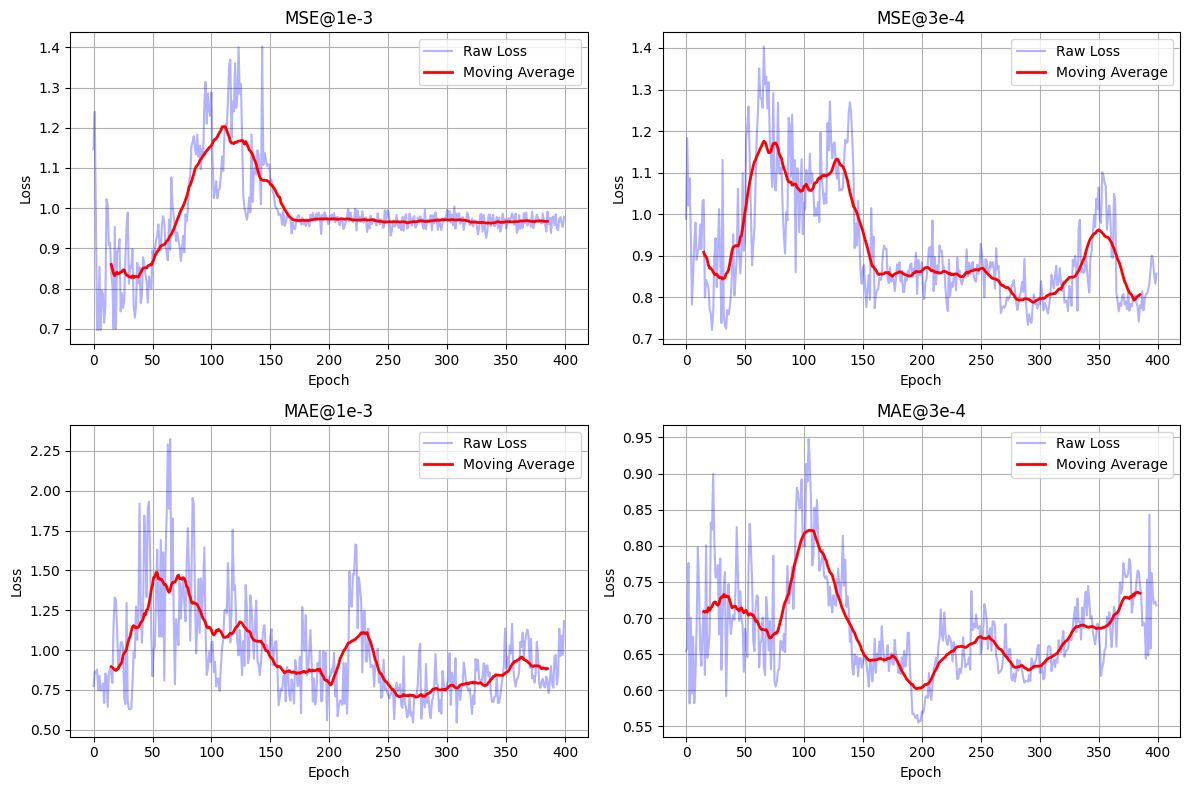

In [38]:
window = 30

# create 2×2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False)
axes = axes.flatten()

for ax, model_name in zip(axes, losses_df.columns):
    # grab the series of losses for this model
    series = losses_df[model_name]
    # compute centered rolling average
    rolling = series.rolling(window=window, center=True).mean()

    # plot raw & smoothed
    ax.plot(series.index, series.values, 
            label='Raw Loss', color='blue', alpha=0.3)
    ax.plot(series.index, rolling.values, 
            label='Moving Average', color='red', linewidth=2)

    # formatting
    ax.set_title(model_name)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.savefig('losses_comparison.svg', dpi=500)
plt.show()